# Chain-of-Thought (CoT) Reasoning
A technique where an LLM breaks down a complex problem into intermediate reasoning steps before giving a final answer. It improves accuracy in tasks requiring logic, math, or multi-step inference.

Key Use Cases

- **CoT**: Best for step-by-step reasoning problems (math, logic puzzles, symbolic reasoning).

Disadvantages

- **CoT**: Can be slower, may propagate errors in intermediate steps, and doesn’t add new knowledge.

- In this case we break down mathematicals questions to 3 subquery and retrieve data from websites

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool
from langchain_classic.prompts import PromptTemplate
from langchain_core.tools.retriever import create_retriever_tool
from pydantic import BaseModel,Field
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from typing import TypedDict, Literal, Annotated, Sequence
from langchain.agents import create_agent
from langgraph.graph.message import add_messages, BaseMessage
from IPython.display import Image, display
from langchain_groq import ChatGroq
from typing import List
from langgraph.prebuilt import tools_condition,ToolNode
from dotenv import load_dotenv
from langchain_classic import hub
import os
load_dotenv()

False

# Using colab for testing another embedding model
- hooshvarelab works fine but retriever Created a new one with mean pooling

In [1]:
! pip install pandas openpyxl langchain-groq langchain==1.2 faiss-cpu langchain-community sentence-transformers pymupdf langchain-huggingface langchain-text-splitters python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 39.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 53.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1
ER

In [3]:
# CEO & Blog
urls = ["https://parspack.com/blog/online-business/what-is-blog",
        "https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping"]
docs = []
for url in urls:
    loader = WebBaseLoader(url)
    docs.extend(loader.load())

In [4]:
# 
import re

def normalize_persian(text: str) -> str:
    text = text.replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [5]:
# docs = [item for sublist in loaders for item in sublist]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=80,separators=["\n\n", "\n", ".", "؟", " "])
texts = text_splitter.split_documents(docs)
for doc in texts:
    doc.page_content = normalize_persian(doc.page_content)
embedding_model = HuggingFaceEmbeddings(model_name="HooshvareLab/bert-base-parsbert-uncased")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k":3})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [6]:
retriever.invoke("کیورد مپینگ یکی از اصلی‌ترین ستون‌های سئو است ")

[Document(id='be1e4eb5-a101-4e71-af8c-83e68084d2ec', metadata={'source': 'https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping', 'title': 'کیورد مپینگ (keyword mapping) چیست و چه کاربردی دارد؟ - پارس پک', 'description': 'کیورد مپینگ (Keyword Mapping) یک استراتژی کلیدی در سئو است. برای برای آشنایی با کیورد مپینگ و کاربرد آن در سئو این مقاله را مطالعه کنید.', 'language': 'fa-IR'}, page_content='آیا کیورد مپینگ فقط برای سئو کاربرد دارد خیر علاوه بر سئو کیورد مپینگ در تبلیغات گوگل Google Ads بازاریابی محتوایی و بهینه سازی تجربه کاربری UX نیز نقش مهمی ایفا می کند'),
 Document(id='ac256e52-98f1-44aa-a4e1-337d6910f6cc', metadata={'source': 'https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping', 'title': 'کیورد مپینگ (keyword mapping) چیست و چه کاربردی دارد؟ - پارس پک', 'description': 'کیورد مپینگ (Keyword Mapping) یک استراتژی کلیدی در سئو است. برای برای آشنایی با کیورد مپینگ و کاربرد آن در سئو این مقاله را مطالعه کنید.', 'language': 'fa-IR'}

In [7]:
# making pipline
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [26]:
# Sub_step fun
def subSteps (state:RAGCoTState) -> RAGCoTState:
    prompt=f"سوال را به ۲-۳ مرحله استدلالی تقسیم کنید: \n\n {state.question}"
    result=llm.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]
    print(f"generate subquery results : {subqs} \n")
    return state.model_copy(update={"sub_steps":subqs}) # keep the other states unchanged


In [19]:
# Retrieve fun
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    print("we are in retrieve node\n")
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})

In [ ]:
# Generate Final Answer
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
شما با استفاده از استدلال و اسناد بازیابی شده به یک سوال پیچیده پاسخ می‌دهید.

سوال: {state.question}

اسناد مرتبط:
{context}

حالا یک پاسخ نهاییِ مستدل و منطقی ارائه دهید.
"""
    print("we are in generate node\n")
    result = llm.invoke(prompt).content.strip()
    
    return state.model_copy(update={"answer": result})

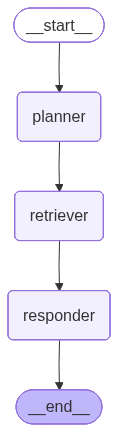

In [27]:
# Graph
builder = StateGraph(RAGCoTState)
builder.add_node("planner", subSteps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [ ]:
if __name__ == "__main__":
    query = "چطور احتمال کلیک روی سایت خود را افزایش دهیم"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\nReasoning Steps:", final["sub_steps"])
    print("\nFinal Answer:\n", final["answer"])

generate subquery results : ['**سوال را به ۲-۳ مرحله استدلالی تقسیم کنیم:**', '1. **شناخت دقیق مخاطب هدف و نیازهای او**', 'تحلیل داده\u200cهای کاربران (نحوه جستجو، رفتار در سایت، فاکتورهای جمعیتی)', 'تعیین نقاط درد، انگیزه\u200cها و ترجیحاتشان', 'این اطلاعات به شما کمک می\u200cکند تا پیام، محتوا و طراحی سایت را به گونه\u200cای تنظیم کنید که بیشترین جذابیت را برای آن دسته از کاربران ایجاد کند.', '2. **بهینه\u200cسازی محتوا، طراحی و تجربه کاربری (UX)**', 'استفاده از عناوین واضح، جذاب و مرتبط با جستجوی کاربران', 'سرعت بارگذاری صفحات، طراحی ریسپانسیو و ناوبری ساده', 'ایجاد محتواهای ارزشمند (مقالات، ویدیو، گرافیک) که پاسخ به سوالات مخاطب باشد', 'بهینه\u200cسازی برای موتورهای جستجو (SEO) تا در نتایج بالاتر ظاهر شود.', '3. **استفاده از CTA\u200cهای مؤثر و کمپین\u200cهای تبلیغاتی هدفمند**', 'قرار دادن فراخوان\u200cهای واضح و جذاب در نقاط کلیدی (بالا، وسط، پایین صفحه)', 'تست A/B برای تعیین بهترین متن، رنگ و موقعیت CTA', 'راه\u200cاندازی کمپین\u200cهای تبلیغاتی (Google Ads, Facebook/Instagram Ad